In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm

# Hyper Parameters

In [2]:
Z_DIM = 128
G_HIDDEN = 64
D_HIDDEN = 64
NUM_CHANNELS = 1
EPOCHS = 100

BATCH_SIZE = 64
generator_lr = 1e-4
discriminator_lr = 2e-4
betas = (.5, .999)

device = torch.device('cuda', index=0)

# Date

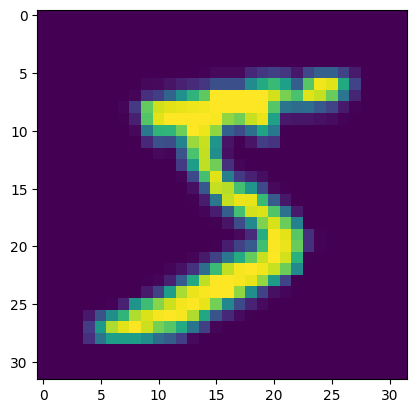

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(size=32),
        transforms.ToTensor(),
    ]
)
dataset = datasets.MNIST('/data', transform=transform, download=True)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

image, label = dataset[0]
plt.imshow(image[0])

# Models

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # N, Z_DIM, 1, 1
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.LeakyReLU(.1, inplace=True),
            # N, (G_HIDDEN*8) x 4, 4
            nn.ConvTranspose2d( G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.LeakyReLU(.1, inplace=True),
            # N, (G_HIDDEN*4) x 8, 8
            nn.ConvTranspose2d( G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.LeakyReLU(.1, inplace=True),
            # N, (G_HIDDEN*2) x 16, 16
            nn.ConvTranspose2d( G_HIDDEN * 2, G_HIDDEN * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 1),
            nn.LeakyReLU(.1, inplace=True),
            # N, G_HIDDEN x 32, 32
            nn.Conv2d(G_HIDDEN, NUM_CHANNELS, 1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # N, NUM_CHANNELS, 32, 32
            nn.Conv2d(NUM_CHANNELS, D_HIDDEN * 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2, 2),
            # N, D_HIDDEN, 16, 16
            nn.Conv2d(D_HIDDEN * 1, D_HIDDEN * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2, 2),
            # N, D_HIDDEN, 8, 8
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2, 2),
            # N, D_HIDDEN, 4, 4
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2, 2),
            # N, D_HIDDEN, 2, 2
            nn.Conv2d(D_HIDDEN * 8, D_HIDDEN * 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2, 2),

            # FC layer
            nn.Flatten(start_dim=1, end_dim=3),
            nn.Linear(D_HIDDEN * 16, 1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input).squeeze(1)


def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(init_weights)
discriminator.apply(init_weights)
print()

# Other Stuff

In [6]:
generator_optimizer = optim.Adam(generator.parameters(), lr=generator_lr, betas=betas)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=betas)

criterion = nn.BCELoss()

exp_number = len(os.listdir('/home/aj/tmp/tblog/'))
logger = SummaryWriter(f'/home/aj/tmp/tblog/exp{exp_number}')

fixed_z = torch.randn(64, Z_DIM, 1, 1, device=device)

# Training Loop

In [7]:
step = 0
for epoch in range(EPOCHS):
    print(f'{epoch = }')
    for real_image, _ in tqdm(dataloader):
        step += 1
        logger.add_scalar('epoch', epoch, step)
        batch_size = real_image.shape[0]
        z = torch.randn(batch_size, Z_DIM, 1, 1, device=device)
        real_image = real_image.to(device)

        #######################
        # train discriminator #
        #######################
        discriminator_optimizer.zero_grad()
        # real label
        # real_label = torch.ones(batch_size, device=device) * .9
        real_label = torch.randint(90, 100, (batch_size,), device=device) / 100
        real_pred = discriminator(real_image)
        real_loss = criterion(real_pred, real_label)
        real_loss.backward()
        logger.add_scalar('d_real_loss', real_loss.item(), step)
        # fake label
        fake_label = torch.zeros(batch_size, device=device)
        with torch.no_grad():
            fake_image = generator(z)
        fake_pred = discriminator(fake_image)
        fake_loss = criterion(fake_pred, fake_label)
        fake_loss.backward()
        logger.add_scalar('d_fake_loss', fake_loss.item(), step)
        # update
        discriminator_loss = real_loss + fake_loss
        # discriminator_loss.backward()
        discriminator_optimizer.step()
        logger.add_scalar('d_loss', discriminator_loss.item(), step)

        ###################
        # train generator #
        ###################
        generator_optimizer.zero_grad()
        real_label = torch.ones(batch_size, device=device)
        fake_image = generator(z)
        pred = discriminator(fake_image)
        generator_loss = criterion(pred, real_label)
        logger.add_scalar('g_loss', generator_loss.item(), step)
        generator_loss.backward()
        generator_optimizer.step()

    # log images
    with torch.no_grad():
        fake_image = generator(fixed_z)
        logger.add_images('fake_images', fake_image, epoch)

epoch = 0


100%|██████████| 938/938 [00:13<00:00, 68.52it/s]


epoch = 1


100%|██████████| 938/938 [00:13<00:00, 69.64it/s]


epoch = 2


100%|██████████| 938/938 [00:13<00:00, 69.18it/s]


epoch = 3


100%|██████████| 938/938 [00:13<00:00, 69.24it/s]


epoch = 4


100%|██████████| 938/938 [00:13<00:00, 68.96it/s]


epoch = 5


100%|██████████| 938/938 [00:13<00:00, 68.72it/s]


epoch = 6


100%|██████████| 938/938 [00:13<00:00, 68.84it/s]


epoch = 7


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]


epoch = 8


100%|██████████| 938/938 [00:13<00:00, 68.85it/s]


epoch = 9


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 10


100%|██████████| 938/938 [00:13<00:00, 68.86it/s]


epoch = 11


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]


epoch = 12


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 13


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


epoch = 14


100%|██████████| 938/938 [00:13<00:00, 68.76it/s]


epoch = 15


100%|██████████| 938/938 [00:13<00:00, 68.67it/s]


epoch = 16


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch = 17


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 18


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 19


100%|██████████| 938/938 [00:13<00:00, 68.67it/s]


epoch = 20


100%|██████████| 938/938 [00:13<00:00, 68.49it/s]


epoch = 21


100%|██████████| 938/938 [00:13<00:00, 68.94it/s]


epoch = 22


100%|██████████| 938/938 [00:13<00:00, 68.73it/s]


epoch = 23


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch = 24


100%|██████████| 938/938 [00:13<00:00, 68.84it/s]


epoch = 25


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 26


100%|██████████| 938/938 [00:13<00:00, 68.76it/s]


epoch = 27


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 28


100%|██████████| 938/938 [00:13<00:00, 68.67it/s]


epoch = 29


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 30


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 31


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 32


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 33


100%|██████████| 938/938 [00:13<00:00, 68.67it/s]


epoch = 34


100%|██████████| 938/938 [00:13<00:00, 68.72it/s]


epoch = 35


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]


epoch = 36


100%|██████████| 938/938 [00:13<00:00, 68.76it/s]


epoch = 37


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 38


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 39


100%|██████████| 938/938 [00:13<00:00, 68.65it/s]


epoch = 40


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]


epoch = 41


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch = 42


100%|██████████| 938/938 [00:13<00:00, 68.65it/s]


epoch = 43


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 44


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch = 45


100%|██████████| 938/938 [00:13<00:00, 68.65it/s]


epoch = 46


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 47


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 48


100%|██████████| 938/938 [00:13<00:00, 68.73it/s]


epoch = 49


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 50


100%|██████████| 938/938 [00:13<00:00, 68.76it/s]


epoch = 51


100%|██████████| 938/938 [00:13<00:00, 68.77it/s]


epoch = 52


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch = 53


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 54


100%|██████████| 938/938 [00:13<00:00, 68.80it/s]


epoch = 55


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 56


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]


epoch = 57


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch = 58


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 59


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]


epoch = 60


100%|██████████| 938/938 [00:13<00:00, 68.78it/s]


epoch = 61


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch = 62


100%|██████████| 938/938 [00:13<00:00, 68.78it/s]


epoch = 63


100%|██████████| 938/938 [00:13<00:00, 68.50it/s]


epoch = 64


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]


epoch = 65


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch = 66


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 67


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 68


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]


epoch = 69


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch = 70


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch = 71


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 72


100%|██████████| 938/938 [00:13<00:00, 68.62it/s]


epoch = 73


100%|██████████| 938/938 [00:13<00:00, 68.67it/s]


epoch = 74


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


epoch = 75


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch = 76


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]


epoch = 77


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]


epoch = 78


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch = 79


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 80


100%|██████████| 938/938 [00:13<00:00, 68.94it/s]


epoch = 81


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 82


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


epoch = 83


100%|██████████| 938/938 [00:13<00:00, 68.57it/s]


epoch = 84


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 85


100%|██████████| 938/938 [00:13<00:00, 68.73it/s]


epoch = 86


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch = 87


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 88


100%|██████████| 938/938 [00:13<00:00, 68.59it/s]


epoch = 89


100%|██████████| 938/938 [00:13<00:00, 68.62it/s]


epoch = 90


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch = 91


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 92


100%|██████████| 938/938 [00:13<00:00, 68.59it/s]


epoch = 93


100%|██████████| 938/938 [00:13<00:00, 68.68it/s]


epoch = 94


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch = 95


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch = 96


100%|██████████| 938/938 [00:13<00:00, 68.80it/s]


epoch = 97


100%|██████████| 938/938 [00:13<00:00, 68.90it/s]


epoch = 98


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch = 99


100%|██████████| 938/938 [00:13<00:00, 68.62it/s]
